# 01 GRU Caltech

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_predictions
from core.util.save_model import save_model, load_parameters
from core.util.get_datasets import split_caltech_data, denormalize_caltech
from core.util.io import read_csv
from core.util.trefor_dataset import TreforData
from core.models import GRU
from core.models.model_training import train_model, test_model
from core.util.hyperparameter_configuration import get_hyperparameter_configuration
from core.util.metrics import mae, rmse, smape

## Normalization/denormalization parameters
Min-Max normalization is completed in split_caltech data, but follows this formula: 

$ caltech_{\text{normalized}} = \frac{caltech - \text{min}(caltech)}{\text{max}(caltech) - \text{min}(caltech)} $

Denormalization is completed at the end of the notebook with this formula:

$ caltech = caltech_{\text{normalized}} \times (\text{max}(caltech) - \text{min}(caltech)) + \text{min}(caltech) $

In [2]:
caltech = read_csv("processed/caltech_ev_sessions.csv")
caltech_min = caltech["Consumption"].min()
caltech_max = caltech["Consumption"].max()

## Configuration
Parameters specific to this experiment

In [3]:
experiment_name = "01_GRU_Caltech"
features = {
    "Month_x": True,
    "Month_y": True,
    "Hour_x": True,
    "Hour_y": True,
    "Day_x": True,
    "Day_y": True,
}
model_input_size = len(features) + 1

Load in the 3 best hyperparameter configurations found by the grid search

In [4]:
parameters = load_parameters(experiment_name)
print(parameters)

{'learning_rate': 0.005, 'batch_size': 128, 'lookback': 36, 'num_layers': 1}


Global hyperparameter configuration

In [5]:
hyperparameters = get_hyperparameter_configuration()
hidden_size = hyperparameters["hidden_size"]
epochs = hyperparameters["epochs"]
horizon = hyperparameters["horizon"]
loss_function = hyperparameters["loss_function"]
dropout_rate = hyperparameters["dropout_rate"]
train_days = hyperparameters["train_days"]
val_days = hyperparameters["val_days"]
test_days = hyperparameters["test_days"]
early_stopper = hyperparameters["early_stopper"]

hyperparameters

{'hidden_size': 16,
 'epochs': 125,
 'horizon': 24,
 'loss_function': <function core.util.loss_functions.zap_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor>,
 'dropout_rate': 0.2,
 'train_days': 16,
 'val_days': 2,
 'test_days': 2,
 'early_stopper': <core.util.early_stop.EarlyStop at 0x7f59d05d23c0>}

If the host has CUDA, it will use the GPU for computation

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Creation of our simple GRU model


In [7]:
def get_model(num_layers: int, lookback: int) -> nn.Module:
    """Get the model for training folds."""
    model = GRU(
        input_size=model_input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        horizon=horizon,
        lookback=lookback,
    )
    model.to(device)
    return model

### Main loop
Iterate all hyperparameter configuration to find the best one.

For each of these, we do the full iteration of epochs (unless early stop occurs) with training and validation.
Lastly, we run the test set on the given model to see how it performs using the metrics MAE, RMSE, and sMAPE.

In [8]:
results = []
for i in range(3):
    # Reset the early stopper
    # Otherwise it can carry information from the previous training and stops too early
    early_stopper.reset()

    # Get parameters for the i'th model
    learning_rate = parameters["learning_rate"]
    batch_size = parameters["batch_size"]
    lookback = parameters["lookback"]
    num_layers = parameters["num_layers"]

    # Loads in the datasets because they can differ for the models (different lookback)
    x_train, y_train, x_val, y_val, x_test, y_test = split_caltech_data(
        lookback=lookback,
        horizon=horizon,
        train_days=train_days,
        val_days=val_days,
        test_days=test_days,
        features=features,
    )

    # Show the shapes of the datasets
    # x_train, x_validation, and x_test: [datapoints, lookback, number of features]
    # y_train, y_validation, and y_test: [datapoints, horizon]
    print(f"x_train: {x_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"x_val: {x_val.shape}")
    print(f"y_val: {y_val.shape}")
    print(f"x_test: {x_test.shape}")
    print(f"y_test: {y_test.shape}")

    # convert to dataset that can use dataloaders
    train_dataset = TreforData(x_train, y_train, device)
    val_dataset = TreforData(x_val, y_val, device)
    test_dataset = TreforData(x_test, y_test, device)

    # initialize the dataloaders, without shuffeling the data between epochs
    training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the i'th model
    experiment_iteration_name = f"01_GRU_trefor_park_iteration_{i}"
    best_train_loss, best_val_loss, best_model = train_model(
        epochs=epochs,
        model=get_model(num_layers, lookback),
        loss_function=loss_function,
        training_loader=training_loader,
        validation_loader=validation_loader,
        learning_rate=learning_rate,
        early_stopper=early_stopper,
    )

    t_loss, predicted = test_model(
        best_model=best_model,
        loss_function=loss_function,
        testing_loader=testing_loader,
    )

    # Flatten the predictions and test set
    # This is done so they can be compared to the tests and calculate the metrics
    flattened_predicted = denormalize_caltech(
        data=predicted.cpu(), original_min=caltech_min, original_max=caltech_max
    ).flatten()
    flattened_test = denormalize_caltech(
        data=y_test.cpu(), original_min=caltech_min, original_max=caltech_max
    ).flatten()

    model_mae = mae(flattened_test, flattened_predicted).detach().item()
    model_rmse = rmse(flattened_test, flattened_predicted)
    model_smape = smape(flattened_test, flattened_predicted).detach().item()

    print(experiment_iteration_name)
    print(f"MAE: {model_mae}")
    print(f"RMSE: {model_rmse}")
    print(f"SMAPE: {model_smape} \n")

    # Append the results so we can pick out the second best
    results.append(
        {
            "sMAPE": model_smape,
            "MAE": model_mae,
            "RMSE": model_rmse,
            "model": best_model,
            "train loss": best_train_loss,
            "validation loss": best_val_loss,
            "y_test": y_test,
            "predicted": predicted,
        }
    )

x_train: torch.Size([3840, 36, 7])
y_train: torch.Size([3840, 24])
x_val: torch.Size([480, 36, 7])
y_val: torch.Size([480, 24])
x_test: torch.Size([480, 36, 7])
y_test: torch.Size([480, 24])


Iterating epochs:   0%|          | 0/125 [00:00<?, ?it/s]

01_GRU_trefor_park_iteration_0
MAE: 5.901095390319824
RMSE: 7.670038660988564
SMAPE: 95.58015441894531 

x_train: torch.Size([3840, 36, 7])
y_train: torch.Size([3840, 24])
x_val: torch.Size([480, 36, 7])
y_val: torch.Size([480, 24])
x_test: torch.Size([480, 36, 7])
y_test: torch.Size([480, 24])


Iterating epochs:   0%|          | 0/125 [00:00<?, ?it/s]

01_GRU_trefor_park_iteration_1
MAE: 5.502407073974609
RMSE: 7.267224210771461
SMAPE: 93.96172332763672 

x_train: torch.Size([3840, 36, 7])
y_train: torch.Size([3840, 24])
x_val: torch.Size([480, 36, 7])
y_val: torch.Size([480, 24])
x_test: torch.Size([480, 36, 7])
y_test: torch.Size([480, 24])


Iterating epochs:   0%|          | 0/125 [00:00<?, ?it/s]

01_GRU_trefor_park_iteration_2
MAE: 6.155362129211426
RMSE: 7.9662488854021545
SMAPE: 101.35334777832031 



In order to select the second best model we sort the results by lowest sMAPE.

sMAPE is the chosen metric as the loss is lower when predictions are larger than the actual value compared to when predictions are lower than the actual value.
$$\hat{y} > y: \text{lower loss} \\ \hat{y} < y: \text{greater loss}$$

In [9]:
# Sort results and extract second best
second_best = sorted(results, key=lambda d: d["sMAPE"])[1]
print(f"sMAPE: {second_best["sMAPE"]}")
print(f"MAE: {second_best["MAE"]}")
print(f"RMSE: {second_best["RMSE"]}")
print(f"Parameters: {parameters}")

model_smape = second_best["sMAPE"]
model_mae = second_best["MAE"]
model_rmse = second_best["RMSE"]
best_model = second_best["model"]
best_train_loss = second_best["train loss"]
best_val_loss = second_best["validation loss"]
y_test = denormalize_caltech(
    data=second_best["y_test"].cpu(),
    original_min=caltech_min,
    original_max=caltech_max,
)
predicted = denormalize_caltech(
    data=second_best["predicted"].cpu(),
    original_min=caltech_min,
    original_max=caltech_max,
)

save_model(
    model=best_model,
    model_name=experiment_name,
    train_loss=best_train_loss,
    val_loss=best_val_loss,
    mae=model_mae,
    rmse=model_rmse,
    smape=model_smape,
    overwrite=True,
)

sMAPE: 95.58015441894531
MAE: 5.901095390319824
RMSE: 7.670038660988564
Parameters: {'learning_rate': 0.005, 'batch_size': 128, 'lookback': 36, 'num_layers': 1}


## Plotting
### Training- and validation loss
Visualize the training and validation loss.

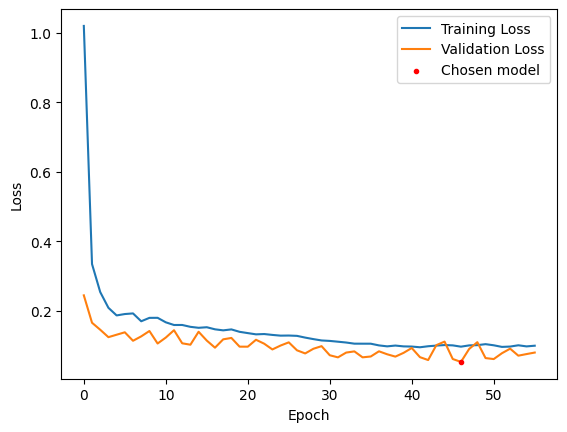

In [10]:
plt.clf()
plt.plot(best_train_loss, label="Training Loss")
plt.plot(best_val_loss, label="Validation Loss")
plt.scatter(
    best_val_loss.index(min(best_val_loss)),
    min(best_val_loss),
    color="red",
    marker=".",
    label="Chosen model",
    zorder=10,
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Predictions- and actual consumption

Plot predictions for the first 7 days, last 7, and a week in the middle of the test set

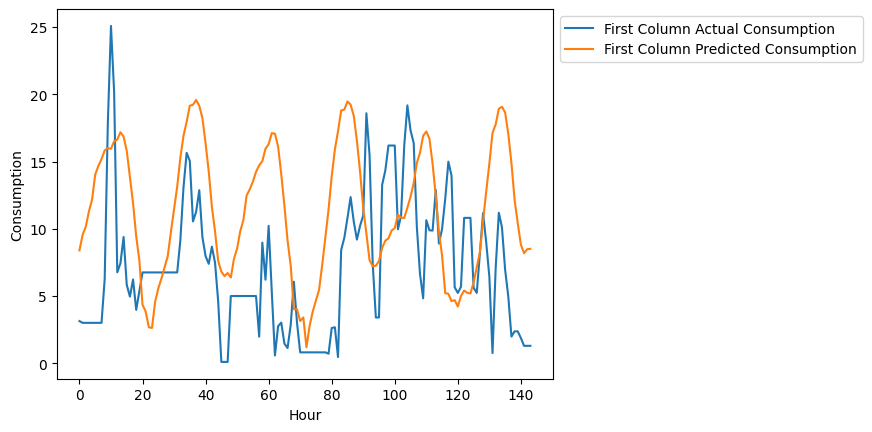

In [11]:
plot_predictions(0, 6, y_test, predicted)

Plot predictions for the last 7 days in the test set

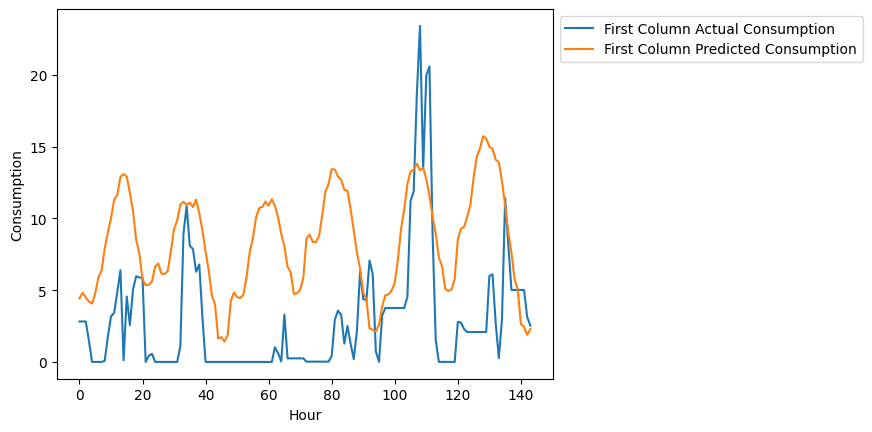

In [12]:
plot_predictions(-7, -1, y_test, predicted)

Plot predictions for 7 days in the in the middle of the test set.

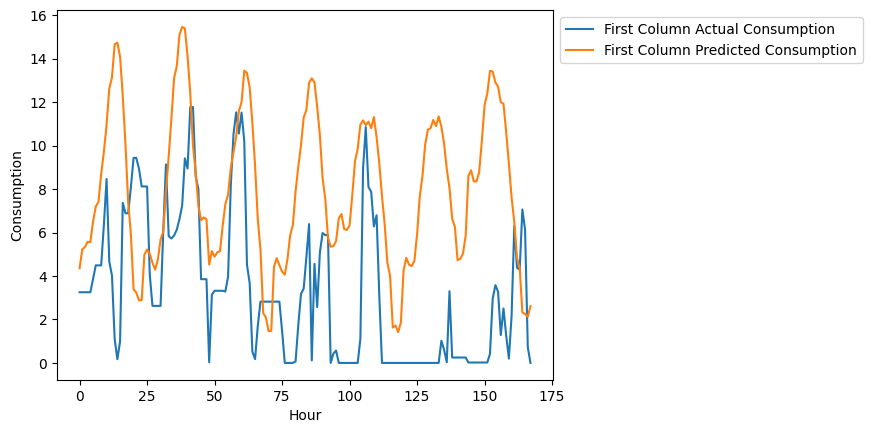

In [13]:
days_count = len(y_test) / 24
plot_predictions(int(days_count / 2), int(days_count / 2 + 7), y_test, predicted)